In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import numpy as np
import pandas as pd
import cvxpy as cp
import gym
import matplotlib.pyplot as plt
from numpy.linalg import LinAlgError
import gurobipy

import sys
sys.path.append('./asebo/')
sys.path.append('./rl/')
from optimizers import Adam
from worker import worker, get_policy
from es import ES

from methods import Gradient_LP, Hessian_LP, Hessian_LP_structured, \
                    get_PTinverse, run_HessianES, aggregate_rollouts_hessianES,\
                    run_asebo

## Training

In [42]:
########### Setting up params ##########
params = {
# 'env_name': 'Swimmer-v2',
'env_name': 'HalfCheetah-v2',
# 'env_name': 'InvertedPendulum-v2',
# 'env_name': 'Reacher-v2',
# 'env_name': 'Hopper-v2',
'steps':1000,
'h_dim':16,
'start':0,
'max_iter':200,
'seed':0,
'k':140, # ASEBO only?
'num_sensings':125,
'log':0,
'threshold':0.995,
'decay':0.99,
'learning_rate':1,#0.05
'filename':'',
'policy':'Linear', # Linear or Toeplitz
'shift':0,
'min':10,
'sigma':1e-4,
'backtracking':True,
'alpha': 1e-6,
'beta': 0.5
}

gradient_estimator = gradient_LP_antithetic_estimator
invhessian_estimator = invHessian_LP_structured_PTinv_estimator

In [43]:
########### Auto Param Setups ##########
params['dir'] = params['env_name'] + params['policy'] + '_h' + str(params['h_dim']) + '_lr' + str(params['learning_rate']) + '_num_sensings' + str(params['num_sensings']) +'_' + params['filename']
env = gym.make(params['env_name'])
params['ob_dim'] = env.observation_space.shape[0]
params['ac_dim'] = env.action_space.shape[0]
params['k'] += -1
# params['alpha'] = 1 # ASEBO only
params['zeros'] = False
if params['log']:
    params['num_sensings'] = 4 + int(3 * np.log(master.N))

## Manuel Test

In [44]:
m = 0
v = 0
master = get_policy(params)

n_samples = params['num_sensings']    
np.random.seed(None)
cov = np.identity(master.N)*(params["sigma"]**2)
mu = np.repeat(0, master.N)
A = np.random.multivariate_normal(mu, cov, n_samples)
A = np.vstack([A, mu]) # Adding a reference evaluation

all_rollouts, timesteps = aggregate_rollouts_hessianES(master, A, params)

In [45]:
%%time
g = gradient_estimator(all_rollouts, A, params["sigma"])

CPU times: user 223 ms, sys: 13.3 ms, total: 236 ms
Wall time: 248 ms


In [46]:
%%time
invH = invhessian_estimator(all_rollouts, A, params["sigma"])

CPU times: user 200 ms, sys: 6.05 ms, total: 206 ms
Wall time: 36.2 ms


In [47]:
sorted(np.linalg.eig(invH)[0])

[-1.9803921568627936,
 -1.9803921568627896,
 -1.9803921568627811,
 -1.9803921568627778,
 -1.9803921568627767,
 -1.9803921568627754,
 -1.980392156862773,
 -1.980392156862771,
 -1.9803921568627694,
 -1.980392156862768,
 -1.9803921568627676,
 -1.980392156862766,
 -1.9803921568627656,
 -1.9803921568627636,
 -1.9803921568627616,
 -1.9803921568627612,
 -1.9803921568627605,
 -1.9803921568627598,
 -1.980392156862758,
 -1.980392156862758,
 -1.9803921568627572,
 -1.980392156862756,
 -1.9803921568627536,
 -1.9803921568627534,
 -1.980392156862753,
 -1.980392156862753,
 -1.9803921568627527,
 -1.9803921568627523,
 -1.980392156862752,
 -1.9803921568627516,
 -1.9803921568627505,
 -1.9803921568627496,
 -1.9803921568627496,
 -1.9803921568627492,
 -1.9803921568627483,
 -1.9803921568627478,
 -1.9803921568627474,
 -1.9803921568627474,
 -1.9803921568627472,
 -1.9803921568627467,
 -1.9803921568627467,
 -1.9803921568627465,
 -1.9803921568627463,
 -1.9803921568627463,
 -1.980392156862746,
 -1.9803921568627456,

## Train

In [49]:
sigmas = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
params_set = [dict(params) for _ in range(len(sigmas))]
for idx, params in enumerate(params_set):
    params['sigma'] = sigmas[idx]

In [50]:
single_params = params_set[1]
master = get_policy(single_params)
ts, rewards, master = run_HessianES(single_params, gradient_estimator, invhessian_estimator, master)

Policy Dimension:  102
Iteration: 1, Leanring Rate: 0.00390625, ollouts: 250, Reward: 6.3392060360590845, Samples: 125
Iteration: 2, Leanring Rate: 9.313225746154785e-10, ollouts: 500, Reward: -298.5929594582887, Samples: 125
Iteration: 3, Leanring Rate: 0.0009765625, ollouts: 750, Reward: -130.56424739247714, Samples: 125
Iteration: 4, Leanring Rate: 0.00048828125, ollouts: 1000, Reward: -121.89527557395547, Samples: 125
Iteration: 5, Leanring Rate: 0.00048828125, ollouts: 1250, Reward: -113.31148901446237, Samples: 125
Iteration: 6, Leanring Rate: 6.103515625e-05, ollouts: 1500, Reward: 224.89297599169842, Samples: 125
Iteration: 7, Leanring Rate: 1.4901161193847656e-08, ollouts: 1750, Reward: 240.99648478443572, Samples: 125
Iteration: 8, Leanring Rate: 1.52587890625e-05, ollouts: 2000, Reward: 276.5428675924415, Samples: 125
Iteration: 9, Leanring Rate: 2.384185791015625e-07, ollouts: 2250, Reward: 300.60752727177527, Samples: 125
Iteration: 10, Leanring Rate: 0.000244140625, ollou

Iteration: 79, Leanring Rate: 7.450580596923828e-09, ollouts: 19750, Reward: 3150.9059290585715, Samples: 125
Iteration: 80, Leanring Rate: 3.814697265625e-06, ollouts: 20000, Reward: 3181.4136706278764, Samples: 125
Iteration: 81, Leanring Rate: 9.313225746154785e-10, ollouts: 20250, Reward: 3069.002972799542, Samples: 125
Iteration: 82, Leanring Rate: 1.52587890625e-05, ollouts: 20500, Reward: 3119.131792283022, Samples: 125
Iteration: 83, Leanring Rate: 9.313225746154785e-10, ollouts: 20750, Reward: 3018.8305458840937, Samples: 125
Iteration: 84, Leanring Rate: 0.0001220703125, ollouts: 21000, Reward: 3046.17646669801, Samples: 125
Iteration: 85, Leanring Rate: 0.000244140625, ollouts: 21250, Reward: 3149.382593054608, Samples: 125
Iteration: 86, Leanring Rate: 6.103515625e-05, ollouts: 21500, Reward: 3215.4405147116704, Samples: 125
Iteration: 87, Leanring Rate: 9.313225746154785e-10, ollouts: 21750, Reward: 1950.8925768192375, Samples: 125
Iteration: 88, Leanring Rate: 0.000244140

Iteration: 156, Leanring Rate: 6.103515625e-05, ollouts: 39000, Reward: 3039.2347366701374, Samples: 125
Iteration: 157, Leanring Rate: 9.313225746154785e-10, ollouts: 39250, Reward: 2894.364344095307, Samples: 125
Iteration: 158, Leanring Rate: 7.62939453125e-06, ollouts: 39500, Reward: 2896.242263003636, Samples: 125
Iteration: 159, Leanring Rate: 1.52587890625e-05, ollouts: 39750, Reward: 2932.9660102989997, Samples: 125
Iteration: 160, Leanring Rate: 3.814697265625e-06, ollouts: 40000, Reward: 2942.0600629754554, Samples: 125
Iteration: 161, Leanring Rate: 7.62939453125e-06, ollouts: 40250, Reward: 2956.037453450791, Samples: 125
Iteration: 162, Leanring Rate: 7.62939453125e-06, ollouts: 40500, Reward: 2971.6369728900145, Samples: 125
Iteration: 163, Leanring Rate: 9.5367431640625e-07, ollouts: 40750, Reward: 3064.502166307486, Samples: 125
Iteration: 164, Leanring Rate: 9.313225746154785e-10, ollouts: 41000, Reward: 2733.1476910836673, Samples: 125
Iteration: 165, Leanring Rate: 0

In [57]:
single_params = params_set[1]
single_params['learning_rate'] = 0.05
master = get_policy(single_params)
ts2, rewards2, master2 = run_asebo(single_params, master)

Iteration: 1, Rollouts: 250, Reward: -671.9898884654408, Alpha: 1, Samples: 125
Iteration: 2, Rollouts: 500, Reward: -339.66332228098213, Alpha: 1, Samples: 125
Iteration: 3, Rollouts: 750, Reward: -190.48414642145477, Alpha: 1, Samples: 125
Iteration: 4, Rollouts: 1000, Reward: 23.147625683303275, Alpha: 1, Samples: 125
Iteration: 5, Rollouts: 1250, Reward: 138.6131166933629, Alpha: 1, Samples: 125
Iteration: 6, Rollouts: 1500, Reward: 1.1682117018011993, Alpha: 1, Samples: 125
Iteration: 7, Rollouts: 1750, Reward: -161.59979838386653, Alpha: 1, Samples: 125


KeyboardInterrupt: 

## Save and Plot

In [60]:
ts = np.load("./data/HalfCheetah-v2Linear_h16_lr1_num_sensings125__hessian_ts.npy")
rewards = np.load("./data/HalfCheetah-v2Linear_h16_lr1_num_sensings125__hessian_rs.npy")

In [52]:
# np.save("./data/{}_hessian.npy".format(params['dir']), master.params)
# np.save("./data/{}_hessian_ts.npy".format(params['dir']), ts)
# np.save("./data/{}_hessian_rs.npy".format(params['dir']), rewards)




In [ ]:
asebo_ts = np.load("./data/InvertedPendulum-v2Toeplitz_h32_lr0.05_k140__asebo_ts.npy")
asebo_rewards = np.load("./data/InvertedPendulum-v2Toeplitz_h32_lr0.05_k140__asebo_rs.npy")

lpgrad_ts = np.load("./data/InvertedPendulum-v2Linear_h32_lr0.05_num_sensings100__LP_ts.npy")
lpgrad_rewards = np.load("./data/InvertedPendulum-v2Linear_h32_lr0.05_num_sensings100__LP_rs.npy")



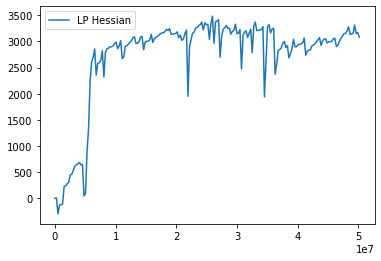

In [61]:
# plt.plot(asebo_ts, asebo_rewards, label="ASEBO")
# plt.plot(lpgrad_ts, lpgrad_rewards, label="LP gradient")
plt.plot(ts, rewards, label="LP Hessian")
plt.legend()


# Testing

In [ ]:
master = get_policy(params)
master.params=np.load("./data/{}_hessian.npy".format(params['dir']))
test_policy = worker(params, master, np.zeros([1, master.N]), 0)


In [ ]:
from gym.wrappers import Monitor
env = Monitor(gym.make(params['env_name']), './video', force=True)
env._max_episode_steps = params['steps']

In [ ]:
def play(env, worker):
    state = env.reset()
    while 1:
        action = worker.policy.evaluate(state)
        action = np.clip(action, worker.env.action_space.low[0], worker.env.action_space.high[0])
        action = action.reshape(len(action), )
        state, reward, done, info = env.step(action)
        env.render()
        if done: 
            break

In [ ]:
play(env, test_policy)

In [ ]:
np.save("./data/{}_hessian_ts.npy".format(params['dir']), ts)
np.save("./data/{}_hessian_rs.npy".format(params['dir']), rewards)

In [ ]:
!open .
